This Jupyter Nookbook is developed for METR 5004 Fundamentals of Atmospheric Science (University of Oklahoma) only. Please do not share or distribute. If you would like to use the model for other purposes, please kindly send me a message. Thank you.

Siyuan Wang (siyuan.wang@noaa.gov)

# Overview

In this session we'll see what a simple chemistry model looks like. We'll learn some fundamentals via a simple example: nighttime NOx chemistry. I'll also show you how I solve the ordinary differential euqations using python.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time

from scipy.integrate import odeint
from scipy.integrate import solve_ivp

plt.style.use('seaborn')

# Chemical mechanism

To run the chemistry model, we need a chemical mechanism first (duh)!

In modelers' eyes, a chemical mechanism consists of two things: <br>
  (1) A list of chemical reactions <br>
  (2) The rate coefficient for each of the chemical reactions <br>

One can manually type in all these. But you wanna be extra careful since sometimes typos can be hard to spot.

In this demo, let's first explore some of the most important nighttime chemical reactions in the troposphere. In the next cell I hand-typed the mechanism to show you what it looks like.

At night we don't have light, therefore we don't have any photochemical reactions (i.e., those triggered by photons)

p.s. a few ground rules when it comes to developing chemical mechanisms for models: don't include weird characters in compound names. Sometimes machines don't like compound names starts with a number. e.g., 1,3-butadiene (an actual legit compound) is probably not a good name for chemistry models, since it starts with a number and contains comma. Some models are case-sensitive too.

In [2]:
# =======================================
# Important nighttime NOx chemistry
# Let's pack them into a pandas DataFrame
# =======================================

# TEMP: Temperature (K)

# For simplicity, lets type type everything in CAPITAL letters
# e.g., TEMP rather than temp or Temp; EXP rather than Exp or exp.
# I will make the model more flexible in the future.

# For chemical species, small letters are okay but you wanna be consistent
# e.g., if you mix No2 with NO2, the model may recognize these as two compounds.
# I say "may" because some model is not case sensitive (like FORTRAN) but honestly no one actually uses No2!

ChemMech_NighttimeNOx = pd.DataFrame({'R0': [' NO + O3 = NO2 ', '1.4E-12*EXP(-1310/TEMP)'],
                                      'R1': [' NO2 + O3 = NO3 ', '1.4E-13*EXP(-2470/TEMP)'],
                                      'R2': [' NO + NO3 = 2*NO2 ', '1.8E-11*EXP(110/TEMP)'],
                                      'R3': [' NO2 + NO3 = N2O5 ', 'KMT03'],
                                      'R4': [' N2O5 = NO2 + NO3 ', 'KMT04']})
ChemMech_NighttimeNOx.index = ['reaction', 'rate_coefficient']

ChemMech_NighttimeNOx.T

,reaction,rate_coefficient
R0,NO + O3 = NO2,1.4E-12*EXP(-1310/TEMP)
R1,NO2 + O3 = NO3,1.4E-13*EXP(-2470/TEMP)
R2,NO + NO3 = 2*NO2,1.8E-11*EXP(110/TEMP)
R3,NO2 + NO3 = N2O5,KMT03
R4,N2O5 = NO2 + NO3,KMT04


Each reaction has a rate coefficient, which can be a constant, or a function of other variables (e.g., temperature). 

Some chemical reactions may have stoichiometric yields, e.g., R2 would produce 2 NO2 molecules for each NO + NO3 reaction. You see here nitrogen atoms are conserved. Normally we don't have "stoichiometric coefficients" for reactants - if they do, they are not "elemental reactions". We don't normally deal with non-elemental reactions.

Now that we have a chemical mechnism, we need to translate it into something the model can read!

Essentially, what a chemistry model does is to solve the so called **"initial value problem"**, i.e., a bunch of ordinary differential equations (ODEs) and an initial condition.

Let's say, we have a simple ODEs system defined by the two chemical reactions: <br>
<ul type="none">
 <li>R1: A + B = 2C </li>
 <li>R2: A = D </li>
</ul>

The rate coefficients of these two are *k1* and *k2*, respectively. We can then write the differential equations describing the "rate of change" of concentrations: <br>
$\frac{d[A]}{dt}$ = -k1[A][B] - k2[A] <br>
$\frac{d[B]}{dt}$ = -k1[A][B] <br>
$\frac{d[C]}{dt}$ = 2k1[A][B] <br>
$\frac{d[D]}{dt}$ = k2[A] <br>

These 4 ODEs together describes this chemical mechanism. I wrote these by hand. Obviously for more complicated mechanisms (even the very simple nighttime chemistry), the ODEs can be very messy and we don't normally trust humans for tasks like this.

Therefore, I have the a few utility functions to process the chemical mechanism:<br>
<ul>
 <li>Process the chemical mechanism</li>
 <li>Generate the derivatives (dC/dt)</li>
 <li>Generate the Jacobian matrix</li>
 <li>Utility function for photolysis frequencies (from MCM)</li>
 <li>Utility function for complex kinetics (from MCM)</li>
</ul>

Some of the stuff is from MCM: the Master Chemical Mechanism: (http://mcm.york.ac.uk) which is a widely used, near-explicit chemical mechanism that is often considered as a benchmark mechanism. It has tens of thousands of reactions!

These utility functions are given in the next cell. You don't necessarily need to understand what exactly I'm doing in the next cell. But you do need to run this cell in order to do other things.

In [3]:
# =================================
# this procedure does two things:
#  - process the chemical mechanism
#  - generate the "derivatives"
# =================================
def get_jac(full_dcodt,rates):
    jac = []
    for i,dcodt in enumerate(full_dcodt):
        rhs_dcodt = dcodt.replace('\n','').replace('\\','').replace(' ','').split('=')[1]
        rhs_dcodt = rhs_dcodt.replace('+',',+').replace('-',',-').split(',')[1:]
        rhs_dcodt2 = [] # convert rates to expressions
        for dcodt in rhs_dcodt:
            # rate_ind = int(dcodt.replace('+rate[','').replace('-rate[','').replace('rate[','').replace(']',''))
            rate_ind = int(dcodt.split('rate[')[1].split(']')[0])
            rhs_dcodt2.append(dcodt.replace('rate['+str(rate_ind)+']', rates[rate_ind]))
        rhs_dcodt = rhs_dcodt2.copy()
        del rhs_dcodt2
        jac_row = []
        for n in range(len(full_dcodt)):
            dfodc = '0.'
            c_n = 'conc['+str(n)+']'
            for dcodt in rhs_dcodt:
                order_c_n = dcodt.split('*').count(c_n)
                if order_c_n==2: dfodc = dfodc + dcodt.split('*')[0]+'*2.*'+c_n
                if order_c_n==1: dfodc = dfodc + dcodt.replace('*'+c_n,'')
            if (dfodc!='0.'): jac_row.append('jac_out[%d,%d] = %s' % (i,n,dfodc))
        jac.append('\n'.join(jac_row))
    return '\n'.join(jac)

def pre_process(in_ChemMech, diagnostic=False): 
    line_limit_rate_expres = 60  #...so we don't end up with ridiculously long lines...
    # --- clean up reactions
    reactions = [in_ChemMech[rnd]['reaction'] for rnd in in_ChemMech.columns]
    reactions = [' '+rnd.replace(' ','')+' ' for rnd in reactions]
    reactions = [rnd.replace('+',' + ') for rnd in reactions]
    reactions = [rnd.replace('=',' = ') for rnd in reactions]
    # --- rate coefficient expressions
    rate_coeff_express_2eval = [str(in_ChemMech[rnd]['rate_coefficient']) for rnd in in_ChemMech.columns]
    rate_coeff_express_2eval = [r.replace('EXP','np.exp') for r in rate_coeff_express_2eval]
    rate_coeff_express_2eval = [r.replace('TEMP','temp') for r in rate_coeff_express_2eval]
    rate_coeff_express_2eval = [r.replace('^','**') for r in rate_coeff_express_2eval]
    # --- generate species list based on that
    species_temp = ','.join(reactions)                                 # concatenate
    species_temp = species_temp.replace(' ','')                        # remove all spaces
    for s in ['+','=','*']: species_temp = species_temp.replace(s,',') # chop chop
    species_temp = list(np.unique(species_temp.split(',')))            # keep only unique stuff
    species_list = []
    for spc in species_temp:
        if (spc.replace('.','').isnumeric()==False) & (len(spc)>0): species_list.append(spc) # delete numerical (stoichiometric coefficients)
    # --- now process RO2 list
    RO2_sum = 'RO2=0.0'
    if 'RO2' in in_ChemMech.T.columns:    
        RO2_list = [r for r in list(in_ChemMech.T['RO2']) if r]
        linelength_current_RO2 = 0
        if (len(RO2_list)>0):
            for RO2 in RO2_list:
                if (linelength_current_RO2<=line_limit_rate_expres):
                    linelength_current_RO2 = linelength_current_RO2 + len('+conc[' + str(species_list.index(RO2)) + ']')
                    RO2_sum = RO2_sum + '+conc[' + str(species_list.index(RO2)) + ']'
                else:
                    linelength_current_RO2 = 0
                    RO2_sum = RO2_sum + '\ \n' + '+conc[' + str(species_list.index(RO2)) + ']'
        RO2_sum = RO2_sum.replace('\ ','\\')
    if (diagnostic): print(RO2_sum)
    # ===============================================================
    # Okay this generates the derivatives, and save as a list strings
    # then these are "evaluated" and recognized as math expressions
    # ===============================================================
    # --- generate the rates for each reaction
    rates_2eval = []
    for ind_reac,reaction in enumerate(reactions):
        all_reactants = [r.replace(' ','') for r in reaction.split(' = ')[0].split(' + ')]
        all_reactants_conc = ['conc['+str(species_list.index(r))+']' for r in all_reactants]
        # rates_2eval.append('rate[' +str(ind_reac) + '] = ' + 'rate_coeff[' +str(ind_reac) + ']*' + '*'.join(all_reactants))
        rates_2eval.append('rate_coeff[' +str(ind_reac) + ']*' + '*'.join(all_reactants_conc))
    # --- generate the derivative for each compound
    derivatives_expres_2eval = []
    full_dcodt_out = []
    for ind_spc,spc in enumerate(species_list):
        dcodt_spc = '0.'
        lengh_rate_expres_currentline = 0
        if (diagnostic): print('# ---')
        if (diagnostic): print('# ', spc)
        for ind_reac,reaction in enumerate(reactions):
            loc_spc = reaction.replace('*',' ').find(' '+spc+' ')
            # --- only do these if found this compound in this reaction
            if loc_spc>=0:
                all_reactants = [r.replace(' ','') for r in reaction.split(' = ')[0].split(' + ')]
                all_products = [r.replace(' ','') for r in reaction.split(' = ')[1].split(' + ')]
                # --- get rid of stoichiometric coefficients
                all_reactants_nostoic, all_products_nostoic = [],[]
                for s in all_reactants:
                    if s.find('*')>=0: all_reactants_nostoic.append(s.split('*')[1])
                    else: all_reactants_nostoic.append(s)
                for s in all_products:
                    if s.find('*')>=0: all_products_nostoic.append(s.split('*')[1])
                    else: all_products_nostoic.append(s)
                # print(all_reactants, all_products, all_products_nostoic)
                # --- get stoiciometric coefficients
                reaction_temp = reaction.replace(' ','')
                for s in ['+','=']: reaction_temp = reaction_temp.replace(s,',') # chop chop
                reaction_temp = reaction_temp.split(',')
                reaction_stoic = []
                for s in reaction_temp:
                    if s.find('*')>=0: reaction_stoic.append(float(s.split('*')[0]))
                    else: reaction_stoic.append(1)
                # --- overall loc for the species in this reaction
                reaction_temp2 = [] # without stoichiometric coefficient
                for s in reaction_temp:
                    if s.find('*')>=0: reaction_temp2.append(s.split('*')[1])
                    else: reaction_temp2.append(s)
                # --- get rate expression for each reaction
                rate_expres = ''
                # for n_reactant,reactant in enumerate(reaction.split(' = ')[0].split(' + ')):
                #     ind_reactant = species_list.index(reactant.replace(' ',''))
                #     rate_expres = rate_expres + '*conc[%d]' % (ind_reactant)
                # rate_expres = 'rate_coeff[' +str(ind_reac) + ']' + rate_expres
                rate_expres = 'rate[' +str(ind_reac) + ']' # + rate_expres
                # --- check if spc is a reactant or a product, then put everything together
                stoic = reaction_stoic[reaction_temp2.index(spc)]
                for (reactants_or_products,sign) in zip([all_reactants_nostoic,all_products_nostoic],['-','+']):
                    for s in reactants_or_products:
                        if (s==spc): # need to search for all entrys!!!                  
                            # --- line length constrain
                            if (lengh_rate_expres_currentline>=line_limit_rate_expres):
                                dcodt_spc = dcodt_spc + '   \ \n'
                                lengh_rate_expres_currentline = 0
                            # --- now make the rate extression
                            if (stoic==1.):
                                dcodt_spc = dcodt_spc + sign + rate_expres
                                lengh_rate_expres_currentline = lengh_rate_expres_currentline + len(rate_expres)
                            else:
                                dcodt_spc = dcodt_spc + sign + str(stoic) + '*' + rate_expres
                                lengh_rate_expres_currentline = lengh_rate_expres_currentline + len(rate_expres)
        # --- output
        full_dcodt = 'dcodt_out[%d] = %s' % (ind_spc,dcodt_spc)
        full_dcodt = full_dcodt.replace('\ ','\\')
        # full_dcodt_out = full_dcodt_out + full_dcodt +'\n'
        full_dcodt_out.append(full_dcodt)
        if (diagnostic): print(full_dcodt)
        derivatives_expres_2eval.append(dcodt_spc.replace('\ ','\\'))
    # --- now get the jacobian metrix
    jac_2eval = get_jac(full_dcodt_out,rates_2eval)
    return species_list, reactions, rates_2eval, derivatives_expres_2eval, rate_coeff_express_2eval, jac_2eval, RO2_sum

# --- photolysis frequencies parameterized as a function of solar zenith angle.
#     directly pulled from MCM
def mcm_jval(SZA):
    jval = np.zeros(100)
    jval[1] = 6.073E-05*np.cos(SZA)**1.743*np.exp(-1*0.474*np.cos(SZA)**-1)
    jval[2] = 4.775E-04*np.cos(SZA)**0.298*np.exp(-1*0.08*np.cos(SZA)**-1)
    jval[3] = 1.041E-05*np.cos(SZA)**0.723*np.exp(-1*0.279*np.cos(SZA)**-1)
    jval[4] = 1.165E-02*np.cos(SZA)**0.244*np.exp(-1*0.267*np.cos(SZA)**-1)
    jval[5] = 2.485E-02*np.cos(SZA)**0.168*np.exp(-1*0.108*np.cos(SZA)**-1)
    jval[6] = 1.747E-01*np.cos(SZA)**0.155*np.exp(-1*0.125*np.cos(SZA)**-1)
    jval[7] = 2.644E-03*np.cos(SZA)**0.261*np.exp(-1*0.288*np.cos(SZA)**-1)
    jval[8] = 9.312E-07*np.cos(SZA)**1.23*np.exp(-1*0.307*np.cos(SZA)**-1) # HNO3
    jval[11] = 4.642E-05*np.cos(SZA)**0.762*np.exp(-1*0.353*np.cos(SZA)**-1)
    jval[12] = 6.853E-05*np.cos(SZA)**0.477*np.exp(-1*0.323*np.cos(SZA)**-1)
    jval[13] = 7.344E-06*np.cos(SZA)**1.202*np.exp(-1*0.417*np.cos(SZA)**-1)
    jval[14] = 2.879E-05*np.cos(SZA)**1.067*np.exp(-1*0.358*np.cos(SZA)**-1)
    jval[15] = 2.792E-05*np.cos(SZA)**0.805*np.exp(-1*0.338*np.cos(SZA)**-1)
    jval[16] = 1.675E-05*np.cos(SZA)**0.805*np.exp(-1*0.338*np.cos(SZA)**-1)
    jval[17] = 7.914E-05*np.cos(SZA)**0.764*np.exp(-1*0.364*np.cos(SZA)**-1)
    jval[18] = 1.482E-06*np.cos(SZA)**0.396*np.exp(-1*0.298*np.cos(SZA)**-1)
    jval[19] = 1.482E-06*np.cos(SZA)**0.396*np.exp(-1*0.298*np.cos(SZA)**-1)
    jval[20] = 7.600E-04*np.cos(SZA)**0.396*np.exp(-1*0.298*np.cos(SZA)**-1)
    jval[21] = 7.992E-07*np.cos(SZA)**1.578*np.exp(-1*0.271*np.cos(SZA)**-1)
    jval[22] = 5.804E-06*np.cos(SZA)**1.092*np.exp(-1*0.377*np.cos(SZA)**-1)
    jval[23] = 2.4246E-06*np.cos(SZA)**0.395*np.exp(-1*0.296*np.cos(SZA)**-1)
    jval[24] = 2.424E-06*np.cos(SZA)**0.395*np.exp(-1*0.296*np.cos(SZA)**-1)
    jval[31] = 6.845E-05*np.cos(SZA)**0.13*np.exp(-1*0.201*np.cos(SZA)**-1)
    jval[32] = 1.032E-05*np.cos(SZA)**0.13*np.exp(-1*0.201*np.cos(SZA)**-1)
    jval[33] = 3.802E-05*np.cos(SZA)**0.644*np.exp(-1*0.312*np.cos(SZA)**-1)
    jval[34] = 1.537E-04*np.cos(SZA)**0.17*np.exp(-1*0.208*np.cos(SZA)**-1)
    jval[35] = 3.326E-04*np.cos(SZA)**0.148*np.exp(-1*0.215*np.cos(SZA)**-1)
    jval[41] = 7.649E-06*np.cos(SZA)**0.682*np.exp(-1*0.279*np.cos(SZA)**-1)
    jval[51] = 1.588E-06*np.cos(SZA)**1.154*np.exp(-1*0.318*np.cos(SZA)**-1) # CH3NO3
    jval[52] = 1.907E-06*np.cos(SZA)**1.244*np.exp(-1*0.335*np.cos(SZA)**-1)
    jval[53] = 2.485E-06*np.cos(SZA)**1.196*np.exp(-1*0.328*np.cos(SZA)**-1)
    jval[54] = 4.095E-06*np.cos(SZA)**1.111*np.exp(-1*0.316*np.cos(SZA)**-1)
    jval[55] = 1.135E-05*np.cos(SZA)**0.974*np.exp(-1*0.309*np.cos(SZA)**-1)
    jval[56] = 4.365E-05*np.cos(SZA)**1.089*np.exp(-1*0.323*np.cos(SZA)**-1)
    jval[61] = 7.537E-04*np.cos(SZA)**0.499*np.exp(-1*0.266*np.cos(SZA)**-1)
    return jval

# --- complex kinetics. directly pulled from MCM website...
def pd_mcm_kinetics(temp,M,N2,O2,H2O,NO=0.,HO2=0.,RO2=0.,NO3=0.):
    KRO2NO = 2.7e-12*np.exp(360/temp)
    KRO2HO2 = 2.91e-13*np.exp(1300/temp)
    KAPHO2 = 5.2e-13*np.exp(980/temp)
    KAPNO = 7.5e-12*np.exp(290/temp)
    KRO2NO3 = 2.3e-12
    KNO3AL = 1.44e-12*np.exp(-1862/temp)
    KDEC = 1.00e+06
    KROPRIM = 2.50e-14*np.exp(-300/temp)
    KROSEC = 2.50e-14*np.exp(-300/temp)
    KCH3O2 = 1.03e-13*np.exp(365/temp)
    K298CH3O2 = 3.5e-13
    K14ISOM1 = 3.00e+7*np.exp(-5300/temp)
    KD0 = 1.10e-05*M*np.exp(-10100/temp)
    KDI = 1.90e+17*np.exp(-14100/temp)
    KRD = KD0/KDI
    FCD = 0.30
    NCD = 0.75-1.27*(np.log10(FCD))
    FD = 10**(np.log10(FCD)/(1+(np.log10(KRD)/NCD)**2))
    KBPAN = (KD0*KDI)*FD/(KD0+KDI)
    KC0 = 3.28e-28*M*(temp/300)**-6.87
    KCI = 1.125e-11*(temp/300)**-1.105
    KRC = KC0/KCI
    FCC = 0.30
    NC = 0.75-1.27*(np.log10(FCC))
    FC = 10**(np.log10(FCC)/(1+(np.log10(KRC)/NC)**2))
    KFPAN = (KC0*KCI)*FC/(KC0+KCI)
    K10 = 1.0e-31*M*(temp/300)**-1.6
    K1I = 5.0e-11*(temp/300)**-0.3
    KR1 = K10/K1I
    FC1 = 0.85
    NC1 = 0.75-1.27*(np.log10(FC1))
    F1 = 10**(np.log10(FC1)/(1+(np.log10(KR1)/NC1)**2))
    KMT01 = (K10*K1I)*F1/(K10+K1I)
    K20 = 1.3e-31*M*(temp/300)**-1.5
    K2I = 2.3e-11*(temp/300)**0.24
    KR2 = K20/K2I
    FC2 = 0.6
    NC2 = 0.75-1.27*(np.log10(FC2))
    F2 = 10**(np.log10(FC2)/(1+(np.log10(KR2)/NC2)**2))
    KMT02 = (K20*K2I)*F2/(K20+K2I)
    K30 = 3.6e-30*M*(temp/300)**-4.1
    K3I = 1.9e-12*(temp/300)**0.2
    KR3 = K30/K3I
    FC3 = 0.35
    NC3 = 0.75-1.27*(np.log10(FC3))
    F3 = 10**(np.log10(FC3)/(1+(np.log10(KR3)/NC3)**2))
    KMT03 = (K30*K3I)*F3/(K30+K3I)
    K40 = 1.3e-3*M*(temp/300)**-3.5*np.exp(-11000/temp)
    K4I = 9.7e+14*(temp/300)**0.1*np.exp(-11080/temp)
    KR4 = K40/K4I
    FC4 = 0.35
    NC4 = 0.75-1.27*(np.log10(FC4))
    F4 = 10**(np.log10(FC4)/(1+(np.log10(KR4)/NC4)**2))
    KMT04 = (K40*K4I)*F4/(K40+K4I)
    KMT05 = 1.44e-13*(1+(M/4.2e+19))
    KMT06 = 1 + (1.40e-21*np.exp(2200/temp)*H2O)
    K70 = 7.4e-31*M*(temp/300)**-2.4
    K7I = 3.3e-11*(temp/300)**-0.3
    KR7 = K70/K7I
    FC7 = 0.81
    NC7 = 0.75-1.27*(np.log10(FC7))
    F7 = 10**(np.log10(FC7)/(1+(np.log10(KR7)/NC7)**2))
    KMT07 = (K70*K7I)*F7/(K70+K7I)
    K80 = 3.2e-30*M*(temp/300)**-4.5
    K8I = 3.0e-11
    KR8 = K80/K8I
    FC8 = 0.41
    NC8 = 0.75-1.27*(np.log10(FC8))
    F8 = 10**(np.log10(FC8)/(1+(np.log10(KR8)/NC8)**2))
    KMT08 = (K80*K8I)*F8/(K80+K8I)
    K90 = 1.4e-31*M*(temp/300)**-3.1
    K9I = 4.0e-12
    KR9 = K90/K9I
    FC9 = 0.4
    NC9 = 0.75-1.27*(np.log10(FC9))
    F9 = 10**(np.log10(FC9)/(1+(np.log10(KR9)/NC9)**2))
    KMT09 = (K90*K9I)*F9/(K90+K9I)
    K100 = 4.10e-05*M*np.exp(-10650/temp)
    K10I = 6.0e+15*np.exp(-11170/temp)
    KR10 = K100/K10I
    FC10 = 0.4
    NC10 = 0.75-1.27*(np.log10(FC10))
    F10 = 10**(np.log10(FC10)/(1+(np.log10(KR10)/NC10)**2))
    KMT10 = (K100*K10I)*F10/(K100+K10I)
    K1 = 2.40e-14*np.exp(460/temp)
    K3 = 6.50e-34*np.exp(1335/temp)
    K4 = 2.70e-17*np.exp(2199/temp)
    K2 = (K3*M)/(1+(K3*M/K4))
    KMT11 = K1 + K2
    K120 = 2.5e-31*M*(temp/300)**-2.6
    K12I = 2.0e-12
    KR12 = K120/K12I
    FC12 = 0.53
    NC12 = 0.75-1.27*(np.log10(FC12))
    F12 = 10**(np.log10(FC12)/(1.0+(np.log10(KR12)/NC12)**2))
    KMT12 = (K120*K12I*F12)/(K120+K12I)
    K130 = 2.5e-30*M*(temp/300)**-5.5
    K13I = 1.8e-11
    KR13 = K130/K13I
    FC13 = 0.36
    NC13 = 0.75-1.27*(np.log10(FC13))
    F13 = 10**(np.log10(FC13)/(1+(np.log10(KR13)/NC13)**2))
    KMT13 = (K130*K13I)*F13/(K130+K13I)
    K140 = 9.0e-5*np.exp(-9690/temp)*M
    K14I = 1.1e+16*np.exp(-10560/temp)
    KR14 = K140/K14I
    FC14 = 0.36
    NC14 = 0.75-1.27*(np.log10(FC14))
    F14 = 10**(np.log10(FC14)/(1+(np.log10(KR14)/NC14)**2))
    KMT14 = (K140*K14I)*F14/(K140+K14I)
    K150 = 8.6e-29*M*(temp/300)**-3.1
    K15I = 9.0e-12*(temp/300)**-0.85
    KR15 = K150/K15I
    FC15 = 0.48
    NC15 = 0.75-1.27*(np.log10(FC15))
    F15 = 10**(np.log10(FC15)/(1+(np.log10(KR15)/NC15)**2))
    KMT15 = (K150*K15I)*F15/(K150+K15I)
    K160 = 8e-27*M*(temp/300)**-3.5
    K16I = 3.0e-11*(temp/300)**-1
    KR16 = K160/K16I
    FC16 = 0.5
    NC16 = 0.75-1.27*(np.log10(FC16))
    F16 = 10**(np.log10(FC16)/(1+(np.log10(KR16)/NC16)**2))
    KMT16 = (K160*K16I)*F16/(K160+K16I)
    K170 = 5.0e-30*M*(temp/300)**-1.5
    K17I = 1.0e-12
    KR17 = K170/K17I
    FC17 = 0.17*np.exp(-51/temp)+np.exp(-temp/204)
    NC17 = 0.75-1.27*(np.log10(FC17))
    F17 = 10**(np.log10(FC17)/(1.0+(np.log10(KR17)/NC17)**2))
    KMT17 = (K170*K17I*F17)/(K170+K17I)
    KMT18 = 9.5e-39*O2*np.exp(5270/temp)/(1+7.5e-29*O2*np.exp(5610/temp))
    KPPN0 = 1.7e-03*np.exp(-11280/temp)*M
    KPPNI = 8.3e+16*np.exp(-13940/temp)
    KRPPN = KPPN0/KPPNI
    FCPPN = 0.36
    NCPPN = 0.75-1.27*(np.log10(FCPPN))
    FPPN = 10**(np.log10(FCPPN)/(1+(np.log10(KRPPN)/NCPPN)**2))
    KBPPN = (KPPN0*KPPNI)*FCPPN/(KPPN0+KPPNI)
    KNO = KRO2NO*NO
    KHO2 = KRO2HO2*HO2*0.706
    KRO2 = 1.26e-12*RO2
    KNO3 = KRO2NO3*NO3
    KTR = KNO + KHO2 + KRO2 + KNO3
    K16ISOM = (KTR*5.18e-04*np.exp(1308/temp)) +(2.76e+07*np.exp(-6759/temp))
    # --- pack... this is a bit sloppy
    k_val = [KRO2NO,KRO2HO2,KAPHO2,KAPNO,KRO2NO3,KNO3AL,KDEC,KROPRIM,KROSEC,KCH3O2,K298CH3O2,K14ISOM1,KBPAN,KFPAN,
             KMT01,KMT02,KMT03,KMT04,KMT05,KMT06,KMT07,KMT08,
             KMT09,KMT10,KMT11,KMT12,KMT13,KMT14,KMT15,KMT16,KMT17,KMT18,KPPN0,KPPNI,KRPPN,FCPPN,NCPPN,FPPN,KBPPN,
             KNO,KHO2,KRO2,KNO3,KTR,K16ISOM]
    k_label = ['KRO2NO','KRO2HO2','KAPHO2','KAPNO','KRO2NO3','KNO3AL','KDEC','KROPRIM','KROSEC','KCH3O2','K298CH3O2','K14ISOM1',
               'KBPAN','KFPAN','KMT01','KMT02','KMT03','KMT04',
               'KMT05','KMT06','KMT07','KMT08','KMT09','KMT10','KMT11','KMT12','KMT13','KMT14','KMT15','KMT16','KMT17',
               'KMT18','KPPN0','KPPNI','KRPPN','FCPPN','NCPPN','FPPN','KBPPN','KNO','KHO2','KRO2','KNO3','KTR','K16ISOM']
    mcm_kin = pd.DataFrame(k_val,index=None).transpose()
    mcm_kin.columns = k_label
    return mcm_kin


# Chemical Kinetics Model: Nuts and Bolts

Here is the main program of the model! I'll briefly walk you thru:<br>
<ol type="1">
<li>Define two important functions for the derivatives and jacobian matrix. These functions are for the ODE solver (you don't call them directly).</li>
<li>Set timing: how long you wanna run the model, how often you wanna output the results. Together they make the time stamps for the model (tout_s)</li>
<li>Process the chemical mechanism using those utility functions</li>
<li>Initialize the arrays, pre-compile a few things (so it runs faster)</li>
<li>Set initial conditions, i.e., initial concentrations.</li>
<li>Set environmental conditions, like temperature, pressure, etc</li>
<li>Main loop that loops over each time step. Inside the loop, we can set time-dependent variables, update kinetics, then call the ODE solver </li>
</ol>

ODE solver is the heart of the model. I'm using `scipy.integrate.solve_ivp` which is flexible and provides quite a few options (many algorithms to solve ODEs). I use BDF (Backward Differentiation Formula) which is ideal/necessary for stiff ODE problems (numerically unstable & challenging for many ODE solvers).

Chemical mechanism: 5 species and 5 reactions
Done processing the mechanism in: 0.001880 seconds
YAMCHA v0: Yet Another Model for Chemistry Happening in the Atmosphere
Total run time: 0.05 days (1.20 hours)
Output frequency: 60.00 seconds | 72 steps
Time elapsed: 0.591969 seconds


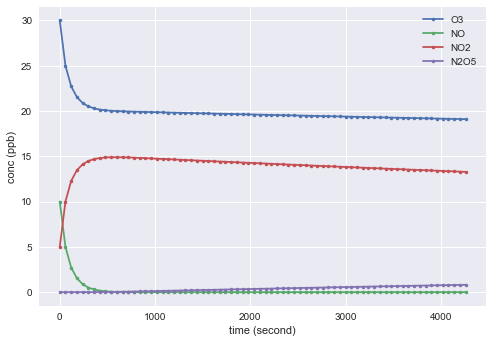

In [4]:
start_time = time.time()

# --- this is the callable that calculates the derivatives: dC/dt
#     I'm using eval() to get the derivatives from the string expressions
#     this is very simple but it does slows things down. one step at a time...
def dcodt(t,conc):
    rate = np.zeros(n_reaction)
    dcodt_out = np.zeros(n_spc)
    for n in range(n_reaction): rate[n] = eval(rates_2eval_compiled[n])
    for n in range(n_spc): dcodt_out[n] = eval(derivatives_2eval_compiled[n])
    return dcodt_out  # np.reshape(dcodt_out, (int(n_spc/n_vec_col),n_vec_col))

# --- this is the callable that calculates the Jacobian matrix
#     will drastically speed things up
def jac(t,conc):
    jac_out = np.zeros((n_spc,n_spc))
    exec(jac_compiled)
    return jac_out

# --- time stamps
total_run_time_days = 0.05        # how long you wanna run the model?
output_frequency_seconds = 60   # how often do you save the output?
tout_s = np.arange(0,total_run_time_days*86400,output_frequency_seconds)  # output time stamps, unit: second

# --- process the chemical mechanism first
in_ChemMech = ChemMech_NighttimeNOx 
species_list, reactions, rates_2eval, derivatives_2eval, rate_coeff_express_2eval, jac_2eval, RO2_sum_2eval = pre_process(in_ChemMech)
n_spc = len(species_list)             # number of species
n_reaction = len(in_ChemMech.columns) # number of reactions
print('Chemical mechanism: %d species and %d reactions' % (n_spc,n_reaction))
print('Done processing the mechanism in: %.6f seconds' % (time.time() - start_time))
start_time = time.time()

# --- prepare arrays
rate_coeff = np.zeros(n_reaction)     
conc = np.zeros((len(tout_s),n_spc))                 # this stores the concentrations. unit: molec/cm3
reaction_rates = np.zeros((len(tout_s),n_reaction))  # this stores the instantaneous rates. unit: molec/cm3/s
conc_init = pd.DataFrame(np.zeros(n_spc)).T          # initial conditions packed into a dataframe so it's easy to use
conc_init.columns = species_list
dcodt_out = np.zeros(n_spc)
jac_out = np.zeros((n_spc,n_spc))

# --- pre-compile so it's much faster to evaluate later
rates_2eval_compiled = [compile(r, '<string>', 'eval') for r in rates_2eval]
derivatives_2eval_compiled = [compile(r, '<string>', 'eval') for r in derivatives_2eval]
jac_compiled = compile(jac_2eval, '<string>', 'exec')
RO2_sum_compiled = compile(RO2_sum_2eval, '<string>', 'exec')
RO2_sum_out_compiled = compile(RO2_sum_2eval.split('=')[1].replace('conc[','conc[i,'), '<string>', 'eval')

# --- this is the solar zenith angle for the j-value parameterization (MCM)
SZA = 0. * np.pi / 180.

# --- special kinetics in MCM: this is directly pulled from MCM. This is sloppy
k_label = ['KRO2NO','KRO2HO2','KAPHO2','KAPNO','KRO2NO3','KNO3AL','KDEC','KROPRIM','KROSEC','KCH3O2',
           'K298CH3O2','K14ISOM1','KBPAN','KFPAN','KMT01','KMT02','KMT03','KMT04','KMT05','KMT06','KMT07',
           'KMT08','KMT09','KMT10','KMT11','KMT12','KMT13','KMT14','KMT15','KMT16','KMT17','KMT18','KPPN0',
           'KPPNI','KRPPN','FCPPN','NCPPN','FPPN','KBPPN','KNO','KHO2','KRO2','KNO3','KTR','K16ISOM']

# --- environmental conditions
temp = 298.     # Kelvin
press = 101325. # Pa
RH = 60.
M = press*6.0232E+17/8.314/temp  # air density. molec/cm3
N2,O2 = 0.78*M, 0.21*M
H2O = 6.1078*np.exp(-1.0E0*(597.3-0.57*(temp-273.16))*18.0/1.986*(1.0/temp-1.0/273.16))*10.0/(1.38E-16*temp)*RH
RO2 = 0         # total RO2 concentration (molec/cm3). MCM needs this. not really saved
RO2_ts = []     # this is a MCM thing

# --- initial condition. need to convert to molec/cm3
conc_init['NO'] = 10.  *press*(6.0232E+8)/(8.314*temp)
conc_init['NO2'] = 5.  *press*(6.0232E+8)/(8.314*temp)
conc_init['O3'] = 30.  *press*(6.0232E+8)/(8.314*temp)

# --- loop over all time steps
for i,t in enumerate(tout_s):
    # --- set time-dependent parameters here
    # --- update kinetics
    jval = mcm_jval(SZA)
    mcm_kinetics = pd_mcm_kinetics(temp,M,N2,O2,H2O)
    for k in k_label: exec("%s = np.array(mcm_kinetics['%s'])[0]" % (k,k))
    # --- need to update all environmental variables, mcm kinetics, jval before eval()
    for n in range(n_reaction): rate_coeff[n] = eval(rate_coeff_express_2eval[n])
    # --- now solve the ODE. Use BDF since it's mostly stiff
    #     accuracy controlled by relative/absolute tolerance (rtol,atol)
    #     integrate step by step, since some env variables may change over the course of time
    if i==0: conc[i,:] = conc_init
    else: conc[i,:] = solve_ivp(dcodt,tout_s[0:2],conc[i-1,:],t_eval=[output_frequency_seconds],
                                jac=jac, 
                                method='BDF',rtol=1e-4,atol=1e+3).y[:,0]
    # --- get instantaneous rates. unit: molec/cm3/s
    for n_reac,reaction in enumerate(reactions):
        reactants = reaction.split(' = ')[0].split(' + ')
        spc_ind = [species_list.index(spc.replace(' ','')) for spc in reactants]
        rate_temp = rate_coeff[n_reac]
        for ind in spc_ind: rate_temp = rate_temp * conc[i,ind]
        reaction_rates[i,n_reac] = rate_temp
    # --- get total RO2
    RO2 = eval(RO2_sum_out_compiled)
    RO2_ts.append(RO2)

# --- pack the concentration outputs (in molec/cm3) into a DataFrame
conc = pd.DataFrame(conc)
conc.columns = species_list
conc['total_RO2'] = RO2_ts  # this is a MCM thing
conc['NOx'] = conc['NO']+conc['NO2']

# --- pack the rate outputs (in molec/cm3/s) into a DataFrame
reaction_rates = pd.DataFrame(reaction_rates)
reaction_rates.columns = in_ChemMech.columns

wrapup_str = 'YAMCHA v0: Yet Another Model for Chemistry Happening in the Atmosphere\n'
wrapup_str = wrapup_str + 'Total run time: %.2f days (%.2f hours)\n' % (total_run_time_days, total_run_time_days*24)
wrapup_str = wrapup_str + 'Output frequency: %.2f seconds | %d steps\n' % (output_frequency_seconds, total_run_time_days*86400/output_frequency_seconds)
wrapup_str = wrapup_str + 'Time elapsed: %.6f seconds' % (time.time() - start_time)
print( wrapup_str )

# --- quick plot. Note the unit conversion: from molecules/cm3 to ppb.
for s in ['O3','NO','NO2','N2O5']:
    plt.plot(tout_s,conc[s]/(press*(6.0232E+8)/(8.314*temp)),'.-',label=s)
plt.xlabel('time (second)')
plt.ylabel('conc (ppb)')
plt.legend()
plt.show()


In this demo, we start with 30 ppb O3 and 10 ppb NO. NO would rapidly react with O3, producing NO2, therefore you can see a sharp drop in O3 which is accompanied by a rapid increase in NO2 as well. Then NO2 is converted into NO3 and eventually N2O5.

Now let's examine if the total reactive nitrogen is conserved? Total reactive nitrogen is usually referred to as NOy, and here it is defined as :<br>
[NOy] = [NO] + [NO2] + [NO3] + 2[N2O5]

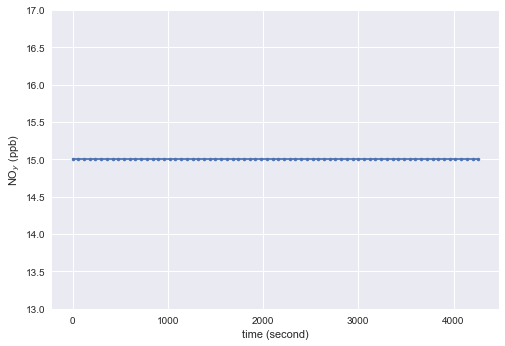

In [5]:
plt.plot(tout_s,(conc['NOx']+conc['NO3']+2*conc['N2O5'])/(press*(6.0232E+8)/(8.314*temp)),'.-',label=s)
plt.xlabel('time (second)')
plt.ylabel('NO$_y$ (ppb)')
plt.ylim([13,17])
plt.show()

In [6]:
# Now let's take another look at the mechanism: 
# NO2 is involved in all reactions
# some are source of NO2 (R0,R2,and R4) and some are sink (R1,R3).

ChemMech_NighttimeNOx.T

,reaction,rate_coefficient
R0,NO + O3 = NO2,1.4E-12*EXP(-1310/TEMP)
R1,NO2 + O3 = NO3,1.4E-13*EXP(-2470/TEMP)
R2,NO + NO3 = 2*NO2,1.8E-11*EXP(110/TEMP)
R3,NO2 + NO3 = N2O5,KMT03
R4,N2O5 = NO2 + NO3,KMT04


# Budget analysis

Let's do a simple budget for NO2, using instantaneous rates (stored in a DataFrame called "reaction_rates").

Basically we plot all NO2 sources and sinks. For sinks, the rates are multiplied by -1. Note for R2 we need to multiply the rate by 2, since two molecules of NO2 are produced per reaction. Note the unit of rates are originally in molecules/cm3/s, and I converted them into ppb/s

As you can see in the figure below, in the very beginning, NO2 is rapidly produced from R0. Later on, NO2 is more or less balanced by R4 and R3. Other reactions are less important.

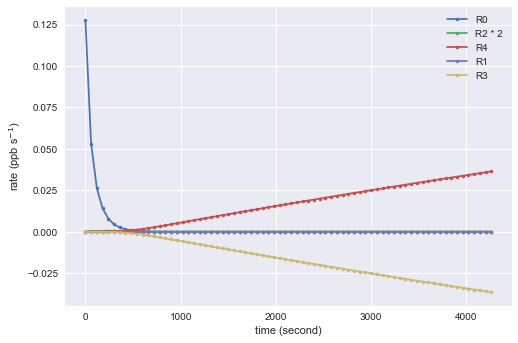

In [7]:
plt.plot(tout_s,reaction_rates['R0']/(press*(6.0232E+8)/(8.314*temp)),'.-',label='R0')
plt.plot(tout_s,2*reaction_rates['R2']/(press*(6.0232E+8)/(8.314*temp)),'.-',label='R2 * 2')
plt.plot(tout_s,reaction_rates['R4']/(press*(6.0232E+8)/(8.314*temp)),'.-',label='R4')
plt.plot(tout_s,-1*reaction_rates['R1']/(press*(6.0232E+8)/(8.314*temp)),'.-',label='R1')
plt.plot(tout_s,-1*reaction_rates['R3']/(press*(6.0232E+8)/(8.314*temp)),'.-',label='R3')
plt.xlabel('time (second)')
plt.ylabel('rate (ppb s$^{-1}$)')
plt.legend()
plt.show()

# Level up!!!

Okay we tried manually typing the chemical mechanism (actually I did that for you) and had a taste of chemistry modeling. 

Now let's spice things up & play around with more complicated mechanism! Obviously for complicated mechanisms we don't wanna manually type it in. 

Fortunately, we can find chemical mechanisms from many places! MCM is a very widely used source of chemical mechanis, and you can customize it too, i.e., if you only wanna study a subset of chemical reactions, you don't need to download the full MCM which can be very big.

Here I have another utility function for you, `load_mcm_kpp(in_mcm_kpp)`, which can load mechanism file generated from the MCM website (http://mcm.leeds.ac.uk/). MCM website supports multiple file formats! I choose KPP here, which is a widely used format among us chemistry nerds.

I have downloaded the inorganic chemistry section from MCM, consisting of 45 reactions. The file is called `MCM_inorganic.kpp` which is shared with you. You need to point to the location where you saved this file. If you run this in Google Colab, you can upload that to your Google Drive and link to your Google Drive. 

You can generate & download your own mechanism files from MCM website! Later I'll show you how to do it, which is quite simple. For now let's use my file.

In [8]:
# ===========================================================
# Okay these are the KPP files generated by the MCM website:
#   http://mcm.leeds.ac.uk/
# Make sure to check "inorganic chemistry"
# Will expand in the future to support other KPP-like formats
# ===========================================================  

mcm_kpp_file = 'MCM_inorganic.kpp'

def load_mcm_kpp(in_mcm_kpp):
    f = open(in_mcm_kpp, "r")
    f_contents = f.readlines()
    f.close()
    # --- find the start of mechanism
    for i,l in enumerate(f_contents):
        if ' RO2 = &' in l:
            ro2_linenum_start = i
            for n,l2 in enumerate(f_contents[ro2_linenum_start+1:]):
                if 'C(ind_' not in l2:
                    ro2_linenum_end = n + ro2_linenum_start
                    break
        if '#EQUATIONS' in l:
            header_linenum = i
            break
    # --- process RO2 list
    RO2_list = ' '.join(f_contents[ro2_linenum_start:ro2_linenum_end+1])
    RO2_list = RO2_list.replace('\n','').replace('&','').replace(' ','').replace('RO2=','').replace('C(ind_','').replace(')','')
    RO2_list = RO2_list.split('+')
    # --- get id, reactions, and rate coeff
    reaction_ind,reaction,ratecoeff = [],[],[]
    for l in f_contents[header_linenum+1:]:
        if (':' in l) & ((';' in l)):
            reaction_ind.append(l.replace('\t','').split(':')[0].split('.}')[0].replace('{',''))
            reaction.append(l.replace('\t','').split(':')[0].split('}')[1])
            ratecoeff.append(l.replace('\t','').split(':')[1].replace(';','').replace('\n',''))
    # --- housekeeping
    reaction_ind = ['R'+str(int(ind)-1) for ind in reaction_ind]
    ratecoeff = [r.replace(' ','') for r in ratecoeff]
    ratecoeff = [r.replace('EXP','np.exp') for r in ratecoeff]
    ratecoeff = [r.replace('TEMP','temp') for r in ratecoeff]
    ratecoeff = [r.replace('D+','e+') for r in ratecoeff]
    ratecoeff = [r.replace('D-','e-') for r in ratecoeff]
    # ratecoeff = ['jval['+r.replace('J(','').split(')')[0].replace(' ','')+']' if 'J(' in r else r for r in ratecoeff]
    ratecoeff = [r.replace('J(','jval[').replace(')',']').replace(' ','') if 'J(' in r else r for r in ratecoeff]
    ratecoeff2 = []
    for r in ratecoeff: # this is sloppy... 
        if 'D' in r:
            loc_of_fucking_D = r.find('D')
            if (r[loc_of_fucking_D-1].isnumeric()) & (r[loc_of_fucking_D+1].isnumeric()):
                ratecoeff2.append(r.replace('D','e'))
            else:
                ratecoeff2.append(r)
        else:
            ratecoeff2.append(r)
    ratecoeff = ratecoeff2
    # --- pack
    mcm_kpp = pd.DataFrame([reaction,ratecoeff,RO2_list]).transpose()
    mcm_kpp.columns = ['reaction', 'rate_coefficient','RO2']
    ChemMech = mcm_kpp.T.copy()
    ChemMech.columns = reaction_ind
    return ChemMech#,RO2_list
    
ChemMech_inorganic = load_mcm_kpp(mcm_kpp_file)

ChemMech_inorganic.T

# # ChemMech['R677'].T


,reaction,rate_coefficient,RO2
R0,O = O3,5.6e-34*N2*(temp/300)**-2.6*O2+6.0e-34*O2*(tem...,
R1,O + O3 =,8.0e-12*np.exp(-2060/temp),None
R2,O + NO = NO2,KMT01,None
R3,O + NO2 = NO,5.5e-12*np.exp(188/temp),None
R4,O + NO2 = NO3,KMT02,None
R5,O1D = O,3.2e-11*np.exp(67/temp)*O2+2.0e-11*np.exp(130/...,None
R6,NO + O3 = NO2,1.4e-12*np.exp(-1310/temp),None
R7,NO2 + O3 = NO3,1.4e-13*np.exp(-2470/temp),None
R8,NO + NO = NO2 + NO2,3.3e-39*np.exp(530/temp)*O2,None
R9,NO + NO3 = NO2 + NO2,1.8e-11*np.exp(110/temp),None


Here we have the same cell from above, including all important pieces of the model. On Line 27, use the chemical mechanism we just loaded: <br>
`in_ChemMech = ChemMech_inorganic` <br>

On Line 45, we can set the solar zenith angle (SZA), which affects the photolysis frequencies. SZA peaks at local noon, and the peak value will depend on time of year, location, etc. SZA is < ~90 degrees during daytime and > ~90 degrees at night.

Let's run the model with SZA = 30 degrees, which is a reasonable guess for SZA at local noon in mid-latitude summer: <br>
`SZA = 30. * np.pi / 180.`

Then run the cell.


Chemical mechanism: 20 species and 45 reactions
Done processing the mechanism in: 0.006743 seconds
YAMCHA v0: Yet Another Model for Chemistry Happening in the Atmosphere
Total run time: 0.05 days (1.20 hours)
Output frequency: 60.00 seconds | 72 steps
Time elapsed: 0.695786 seconds


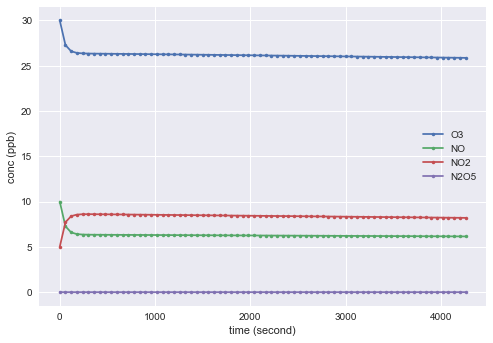

In [9]:
start_time = time.time()

# --- time stamps
total_run_time_days = 0.05        # how long you wanna run the model?
output_frequency_seconds = 60   # how often do you save the output?
tout_s = np.arange(0,total_run_time_days*86400,output_frequency_seconds)  # output time stamps, unit: second

# --- process the chemical mechanism first
in_ChemMech = ChemMech_inorganic 
species_list, reactions, rates_2eval, derivatives_2eval, rate_coeff_express_2eval, jac_2eval, RO2_sum_2eval = pre_process(in_ChemMech)
n_spc = len(species_list)             # number of species
n_reaction = len(in_ChemMech.columns) # number of reactions
print('Chemical mechanism: %d species and %d reactions' % (n_spc,n_reaction))
print('Done processing the mechanism in: %.6f seconds' % (time.time() - start_time))
start_time = time.time()

# --- prepare arrays
rate_coeff = np.zeros(n_reaction)     
conc = np.zeros((len(tout_s),n_spc))                 # this stores the concentrations. unit: molec/cm3
reaction_rates = np.zeros((len(tout_s),n_reaction))  # this stores the instantaneous rates. unit: molec/cm3/s
conc_init = pd.DataFrame(np.zeros(n_spc)).T          # initial conditions packed into a dataframe so it's easy to use
conc_init.columns = species_list
dcodt_out = np.zeros(n_spc)
jac_out = np.zeros((n_spc,n_spc))

# --- pre-compile so it's much faster to evaluate later
rates_2eval_compiled = [compile(r, '<string>', 'eval') for r in rates_2eval]
derivatives_2eval_compiled = [compile(r, '<string>', 'eval') for r in derivatives_2eval]
RO2_sum_compiled = compile(RO2_sum_2eval, '<string>', 'exec')
jac_compiled = compile(jac_2eval, '<string>', 'exec')
RO2_sum_out_compiled = compile(RO2_sum_2eval.split('=')[1].replace('conc[','conc[i,'), '<string>', 'eval')

# --- this is the solar zenith angle for the j-value parameterization (MCM)
SZA = 30. * np.pi / 180.

# --- special kinetics in MCM: this is directly pulled from MCM. This is sloppy
k_label = ['KRO2NO','KRO2HO2','KAPHO2','KAPNO','KRO2NO3','KNO3AL','KDEC','KROPRIM','KROSEC','KCH3O2',
           'K298CH3O2','K14ISOM1','KBPAN','KFPAN','KMT01','KMT02','KMT03','KMT04','KMT05','KMT06','KMT07',
           'KMT08','KMT09','KMT10','KMT11','KMT12','KMT13','KMT14','KMT15','KMT16','KMT17','KMT18','KPPN0',
           'KPPNI','KRPPN','FCPPN','NCPPN','FPPN','KBPPN','KNO','KHO2','KRO2','KNO3','KTR','K16ISOM']

# --- environmental conditions
temp = 298.     # Kelvin
press = 101325. # Pa
RH = 60.
M = press*6.0232E+17/8.314/temp  # air density. molec/cm3
N2,O2 = 0.78*M, 0.21*M
H2O = 6.1078*np.exp(-1.0E0*(597.3-0.57*(temp-273.16))*18.0/1.986*(1.0/temp-1.0/273.16))*10.0/(1.38E-16*temp)*RH
RO2 = 0         # total RO2 concentration (molec/cm3). MCM needs this. not really saved
RO2_ts = []     # this is a MCM thing

# --- initial condition. need to convert to molec/cm3
conc_init['NO'] = 10.  *press*(6.0232E+8)/(8.314*temp)
conc_init['NO2'] = 5.  *press*(6.0232E+8)/(8.314*temp)
conc_init['O3'] = 30.  *press*(6.0232E+8)/(8.314*temp)

# --- loop over all time steps
for i,t in enumerate(tout_s):
    # --- set time-dependent parameters here
    # --- update kinetics
    jval = mcm_jval(SZA)
    mcm_kinetics = pd_mcm_kinetics(temp,M,N2,O2,H2O)
    for k in k_label: exec("%s = np.array(mcm_kinetics['%s'])[0]" % (k,k))
    # --- need to update all environmental variables, mcm kinetics, jval before eval()
    for n in range(n_reaction): rate_coeff[n] = eval(rate_coeff_express_2eval[n])
    # --- now solve the ODE. Use BDF since it's mostly stiff
    #     accuracy controlled by relative/absolute tolerance (rtol,atol)
    #     pass in jacobian matrix. 3x faster
    #     integrate step by step, since some env variables may change over the course of time
    if i==0: conc[i,:] = conc_init
    else: conc[i,:] = solve_ivp(dcodt,tout_s[0:2],conc[i-1,:],t_eval=[output_frequency_seconds],
                                jac=jac, method='BDF',rtol=1e-4,atol=1e+3).y[:,0]
    # --- get instantaneous rates. unit: molec/cm3/s
    for n_reac,reaction in enumerate(reactions):
        reactants = reaction.split(' = ')[0].split(' + ')
        spc_ind = [species_list.index(spc.replace(' ','')) for spc in reactants]
        rate_temp = rate_coeff[n_reac]
        for ind in spc_ind: rate_temp = rate_temp * conc[i,ind]
        reaction_rates[i,n_reac] = rate_temp
    # --- get total RO2
    RO2 = eval(RO2_sum_out_compiled)
    RO2_ts.append(RO2)

# --- pack the concentration outputs (in molec/cm3) into a DataFrame
conc = pd.DataFrame(conc)
conc.columns = species_list
conc['total_RO2'] = RO2_ts  # this is a MCM thing
conc['NOx'] = conc['NO']+conc['NO2']

# --- pack the rate outputs (in molec/cm3/s) into a DataFrame
reaction_rates = pd.DataFrame(reaction_rates)
reaction_rates.columns = in_ChemMech.columns

wrapup_str = 'YAMCHA v0: Yet Another Model for Chemistry Happening in the Atmosphere\n'
wrapup_str = wrapup_str + 'Total run time: %.2f days (%.2f hours)\n' % (total_run_time_days, total_run_time_days*24)
wrapup_str = wrapup_str + 'Output frequency: %.2f seconds | %d steps\n' % (output_frequency_seconds, total_run_time_days*86400/output_frequency_seconds)
wrapup_str = wrapup_str + 'Time elapsed: %.6f seconds' % (time.time() - start_time)
print( wrapup_str )

# --- quick plot. Note the unit conversion: from molecules/cm3 to ppb.
for s in ['O3','NO','NO2','N2O5']:
    plt.plot(tout_s,conc[s]/(press*(6.0232E+8)/(8.314*temp)),'.-',label=s)
plt.xlabel('time (second)')
plt.ylabel('conc (ppb)')
plt.legend()
plt.show()


First thing we noticed is that, the total time needed to run the model with this more compliecated mechanism (45 reactions) is noticibly longer than the simple one (5 reactions). Of course how long it takes to run the model depends also on the total model run time and output frequency, as well as how accurate you want it to be (controlled by tolerance settings in the solver, atol and rtol). Also the machine you're using to run the model will affect the performance too. I have optimized the model to improve the performance (e.g., providing the analytical Jacobian matrix, optimizing the maths in the function that calculates derivatives).

As you can see from the plot above, O3 is still rapidly consumed by NO, producing NO2, in the early stage. But the difference here compared to the previous nighttime case is, NO does not drop to zero, because of the photolysis of NO2. Also N2O5 is very low during daytime as well, because it can also undergo photolysis.

In this case we keep all environmental variables (temperature, solar zenith angle) constant. If you wanna let them vary with time, you can update the values inside the main time loop.

In the class we discussed the NOx null cycle: with light and only NO-NO2 interconversion, there will be no net O3 production or destruction, since the odd oxygen will just exchange between NO2 and O3. Therefore if we plot the sum of O3 and NO2 here, the sum remains more or less constant.

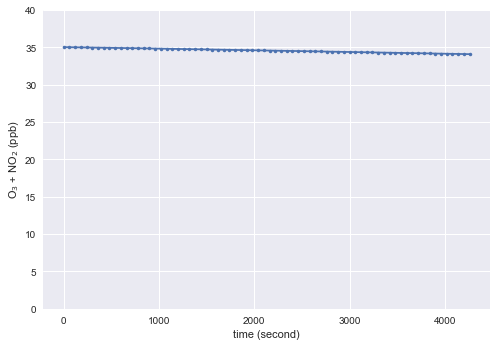

In [10]:
plt.plot(tout_s,(conc['O3']+conc['NO2'])/(press*(6.0232E+8)/(8.314*temp)),'.-')
plt.xlabel('time (second)')
plt.ylabel('O$_3$ + NO$_2$ (ppb)')
plt.ylim([0,40])
plt.show()

Okay I hope you now have an idea about simple chemistry model and how it works. In reality people do more complicated things with models like this, e.g., multi-phase chemistry, gas-aerosol/cloud interactions, aerosol dynamics, ... but the idea is the same. People also use chemistry models like this for other purposes, e.g., develop chemical mechanisms, better understand measurements, etc. 